# Accessing S3 via PySpark
## Start Spark

Assume that we are using the PySpark kernel

In [2]:
import os

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Read from S3

In [3]:
s3File = spark.read.text("s3://multimedia-commons/index.html")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
s3File.first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(value='<!DOCTYPE html>')

## Read binary files

In [5]:
# https://sparkbyexamples.com/spark/spark-read-binary-file-into-dataframe/
df = spark.read.format("binaryFile").load("s3://multimedia-commons/data/images/000/24a/00024a73d1a4c32fb29732d56a2.jpg")
df.printSchema()
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://multimedia-c...|2019-03-31 01:07:42| 40382|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+

In [6]:
# https://stackoverflow.com/questions/58611888/how-is-spark-reading-my-image-using-the-image-format
df = spark.read.format("image").load("s3://multimedia-commons/data/images/000/24a/00024a73d1a4c32fb29732d56a2.jpg")
df.printSchema()
df.select("image.height","image.width","image.nChannels", "image.mode", "image.data").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)

+------+-----+---------+----+--------------------+
|height|width|nChannels|mode|                data|
+------+-----+---------+----+--------------------+
|   260|  500|        3|  16|[00 00 00 00 00 0...|
+------+-----+---------+----+--------------------+

In [92]:
#img_bytes = df.select("image.data").take(1)
img_bytes = df.select("image.data").first()
len(img_bytes)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1

In [94]:
len(img_bytes[0])  # Should be 40382  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

390000

In [148]:
df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['image']

In [182]:
def img2np(image_row):
    image_row_dict = image_row.asDict()
    image_dict = image_row_dict['image'].asDict()

    # From the code for toNDArray - https://spark.apache.org/docs/2.3.0/api/python/_modules/pyspark/ml/image.html
    height = image_dict['height']
    width = image_dict['width']
    nChannels = image_dict['nChannels']
    return np.ndarray(
            shape=(height, width, nChannels),
            dtype=np.uint8,
            buffer=image_dict['data'],
            strides=(width * nChannels, nChannels, 1))

#df.rdd.map(lambda x: img2np(x)).collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [197]:
# https://stackoverflow.com/a/69215982/11262633
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import col
from pyspark.sql import Row

#img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())
img2vec = F.udf(lambda x: ImageSchema.toNDArray(x))
#img2vec = F.udf(lambda x: img2vec0(x))
#def img2vec0(image):
    # From the code for toNDArray - https://spark.apache.org/docs/2.3.0/api/python/_modules/pyspark/ml/image.html
#     height = image.height
#     width = image.width
#     nChannels = image.nChannels
#     return np.ndarray(
#             shape=(height, width, nChannels),
#             dtype=np.uint8,
#             buffer=image.data,
#             strides=(width * nChannels, nChannels, 1))
#    return type(image)

print(f'Image fields = {ImageSchema.imageFields}')
# https://stackoverflow.com/a/62454907/11262633
# https://stackoverflow.com/questions/36584812/pyspark-row-wise-function-composition
#df_img = df.select('image.*')
# df_new = df_img.withColumn('vecs',img2vec(F.struct(*list(df_img.columns))))
#df_new = df.withColumn('vecs',img2vec(F.struct([f'image.{col_name}' for col_name in df_img.columns])))
#df_new = df.withColumn('vecs',img2vec('image'))
#df_new = df.withColumn('vecs',ImageSchema.toNDArray(col('image'))) #image argument should be pyspark.sql.types.Row
#df_new = df.transform(ImageSchema.toNDArray)
#df_new = df.withColumn('vecs',img2vec(col('image')))
#df_new = df.withColumn('vecs',np.ndarray(shape=(df.image.height, df.image.width)))
rdd = df.rdd.map(img2np)

x = rdd.collect()
x[0].shape
#df_new = rdd.toDF(['img_np'])
#df_new = spark.createDataFrame(rdd, schema = ['img_np'])
#df_new.show()
#df_new.select('img_np').first().asDict().keys()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Image fields = ['origin', 'height', 'width', 'nChannels', 'mode', 'data']
(260, 500, 3)

In [201]:
# https://stackoverflow.com/a/69215982/11262633
import pyspark.sql.functions as F
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import DenseVector, VectorUDT

img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())

print(f'Image fields = {ImageSchema.imageFields}')
df_new = df.withColumn('vecs',img2vec('image'))
df_new.show()
#df_new.select('vecs').first().asDict().keys()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Image fields = ['origin', 'height', 'width', 'nChannels', 'mode', 'data']
+--------------------+--------------------+
|               image|                vecs|
+--------------------+--------------------+
|{s3://multimedia-...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+

dict_keys(['vecs'])

In [212]:
row_dict = df_new.first().asDict()
img_vec = row_dict['vecs']
print(img_vec.shape, type(img_vec))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(390000,) <class 'pyspark.ml.linalg.DenseVector'>

In [214]:
img_dict = row_dict['image']
width = img_dict['width']
height = img_dict['height']
nChannels = img_dict['nChannels']

img_np = img_vec.reshape(height, width, nChannels)

# img_np = np.ndarray(
#             shape=(height, width, nChannels),
#             dtype=np.uint8,
#             buffer=img_dict['data'],
#             strides=(width * nChannels, nChannels, 1))
# img_np[47,106] # Gives [1, 16, 104].  Need [103,  16,   9]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [220]:
m = np.ma.masked_greater(img_np, 100)
m_mask = m.mask

args = np.argwhere(m_mask)

for idx, (r, c, _) in enumerate(args):
    print(r, c, img_np[r,c])
    if idx > 5:
        break    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

46 136 [  0.  13. 101.]
47 104 [  1.  15. 102.]
47 105 [  1.  16. 104.]
47 106 [  1.  16. 104.]
47 107 [  1.  16. 104.]
47 108 [  1.  16. 104.]
47 109 [  1.  15. 105.]

In [11]:
getLen = F.udf(lambda x:len(x))
df_with_len = df_new.withColumn('len',getLen('vecs'))
df_with_len.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------+
|               image|                vecs|   len|
+--------------------+--------------------+------+
|{s3://multimedia-...|[0.0,0.0,0.0,0.0,...|390000|
+--------------------+--------------------+------+

In [12]:
first = df.select('image.data').first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
import numpy as np
first_dict = first.asDict()
img_np_from_data = np.asarray(first_dict['data'])
np.histogram(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(array([251543,  35427,  24677,  15188,  10118,  10273,   9756,   9747,
        12729,  10542]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))

In [14]:
img_np_from_data.shape, len(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

((390000,), 390000)

In [59]:
set(img_np_from_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [88]:
img_np_from_data.reshape(260,500,3)[47,106]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([  1,  16, 104], dtype=uint8)

In [16]:
df_with_len.createOrReplaceTempView("temp_table_name")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [209]:
img_np[47,106]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([  1.,  16., 104.])

In [208]:
# Per https://stackoverflow.com/a/57863292/11262633
%%spark -o img_np_spark
img_np_spark = img_np

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
unknown magic command '%spark'
UnknownMagic: unknown magic command '%spark'



In [57]:
%%local
print(row['image'].keys())
print(len(row['image']['data']))
vec = row['vecs']
print(vec.keys())
print(len(row['vecs']['values']))
print(vec['values'][:10],row['image']['data'][:10])

odict_keys(['origin', 'height', 'width', 'nChannels', 'mode', 'data'])
520000
odict_keys(['type', 'values'])
390000
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] AAAAAAAAAA


In [71]:
%%local
print(h,w,c)
print(img_np.shape)
print(img_np.dtype)
img_np

260 500 3
(260, 500, 3)
int32


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=int32)

(500, 260)


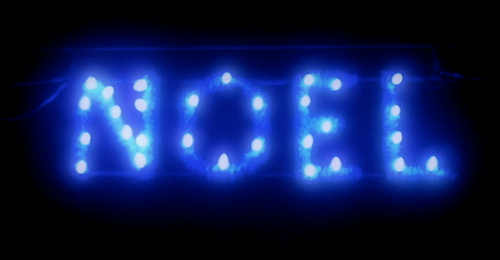

after img.show


In [75]:
%%local 
from PIL import Image
from io import StringIO
import numpy as np
#from io import BytesIO

#from matplotlib import pyplot as plt

#print(df_for_local.columns)  #['image', 'vecs', 'len'],
row = df_for_local.iloc[0]
h = row['image']['height']
w = row['image']['width']
c = row['image']['nChannels']
#print(h,w,type(h),type(w))

vec = row['vecs']
img_np = np.array(vec['values']).reshape(h,w,c).astype(np.uint8)
img = Image.fromarray(img_np)
print(img.size)
#print(type(vec))
#img_np = np.asarray(Image.open(StringIO(img_np)))
#plt.imshow(img_np)
#img = Image.fromarray(img_np)

# https://stackoverflow.com/a/26649884/11262633
display(img)
print('after img.show')

#img = Image.open(

In [85]:
%%local
img_np[47,106]

array([  1,  16, 104], dtype=uint8)

In [118]:
%%local
#https://stackoverflow.com/questions/66207434/how-to-extract-images-from-pyspark-dataframe-to-numpy
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

row = df_for_local.iloc[0]
img_data = row['image']['data']
img_pil = array_to_img(img_data)
img_np_tf = img_to_array(img_pil)
print(f'img_np_tf={img_np_tf.shape}')

ModuleNotFoundError: No module named 'tensorflow'